<p style="text-align: right;">Daniel Pipkin - Oct 2015</p>

# Analyzing NYC Subway Data and Weather

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ggplot import *
from scipy import stats
import datetime
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
df = pd.read_csv('turnstile_weather_v2.csv')

In 2014 the New York City subway system averaged 5,597,551 riders on a weekday; weekends were even higher.<sup>1</sup> With such a large group of people, this can be a useful dataset to study motivations behind using public transit. Do people ride more on weekends? How many riders do we get on the weekends and nights? Are most people commuting to work? How much traffic do the subway lines get on a full moon? It can be fun to look at whether or not these conditions affect rider behavior. However, care must be taken to make sure we are drawing accurate conclusions.

## What are we trying to answer?

There are so many questions that can be asked, so let's narrow the scope. Combining weather data with rider data that the Metropolitan Transportation Authority (MTA) supplies, we can test the relationship between rain and the volume of riders on the underground transit.  
I spent about a week in New York one summer and I remember things in Manhattan being fairly close &mdash; close enough to walk. Distance wasn't a problem. Melting in the urban heat island was. I can see why people would ride the subway to escape the doom from above.  
"Hot" can be difficult to classify. Do we put a cutoff at 90&deg;F or 95&deg;F? However, it's pretty obvious when it rains. The clean, tidy data from Udacity gives us a very clear idea of what days it rained. Enough rambling, here's the question:  
  
**Does rain increase the MTA subway ridership?**  


In [18]:
# It either rained or it didn't
print df.rain.unique()

[0 1]


## Proving ourselves wrong

Let's start with the idea that rain doesn't affect ridership at all.  
More specifically, we'll say that the average hourly entries of rainy days and non-rainy days are the same. This is our [null hypothesis](https://en.wikipedia.org/wiki/Null_hypothesis).  
**H<sub>0</sub>: &mu;<sub>r</sub> = &mu;<sub>n</sub>**  
**where &mu;<sub>r</sub> and &mu;<sub>n</sub> are the averages of rainy and non-rainy days respectively*  
  
Now if we find enough evidence against that statement, we can confidently say that there are more riders on average on rainy days, or:  
**H<sub>A</sub>: &mu;<sub>r</sub> > &mu;<sub>n</sub>**  

How confident should we be? I am going to take the conservative approach and say that I want to be 99% sure that it changes riders' behavior.  
In statistical language, this means that we have **&alpha; = 0.01**. Because we are assuming<sup>2</sup> that the averages are the same, if we are wrong we want strong evidence. We would hate to look wrong in front of our friends.

## Testing... testing...

There are many ways to test our hypothesis, only some are good tests. First, we have to check if our data is normally distributed.

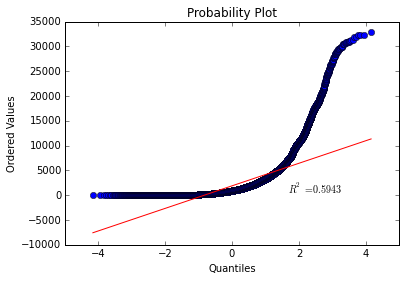

The chances that our data is normally distributed: 0.0 %


In [44]:
stats.probplot(df['ENTRIESn_hourly'], plot=plt)
plt.show()
W, p = stats.shapiro(df['ENTRIESn_hourly'])
print "The chances that our data is normally distributed:", p * 100, "%"

Oh no! Looks like we are going to need a non-parametric test.<sup>3</sup> A popular non-parametric test is the Mann-Whitney U-test. We can use this test to see if two samples came from the same population. In other words, it will tell us whether or not our rain/non-rainy days have any difference.

In [47]:
rainy_entries = df[df['rain'] == 1]['ENTRIESn_hourly']
non_rainy_entries = df[df['rain'] == 0]['ENTRIESn_hourly']
stats.mannwhitneyu(rainy_entries, non_rainy_entries)

MannwhitneyuResult(statistic=153635120.5, pvalue=nan)

Because the `scipy.stats` implementation is giving us trouble with the p-value, we can use the normal approximation of U.<sup>4</sup> 

In [50]:
# Calculate Z
x = rainy_entries
y= non_rainy_entries
m_u = len(x)*len(y)/2
sigma_u = np.sqrt(len(x)*len(y)*(len(x)+len(y)+1)/12)
z = (u - m_u)/sigma_u

pval = 2*stats.norm.cdf(z)
print pval

5.48269387142e-06


Here, our p-value is much less than our **&alpha;** (0.00000548) so we can say with confidence that our populations are different. Now let's see who has the higher average.

In [54]:
print "rainy average:", np.mean(rainy_entries)
print "non-rainy average:", np.mean(non_rainy_entries)

rainy average: 2028.19603547
non-rainy average: 1845.53943866


With all of this evidence, we can say with a 99% confidence that rainy days have a higher average rider volume than non-rainy days! \\(^-^)/. I guess being wrong isn't always so bad.

## Linear Regression

---

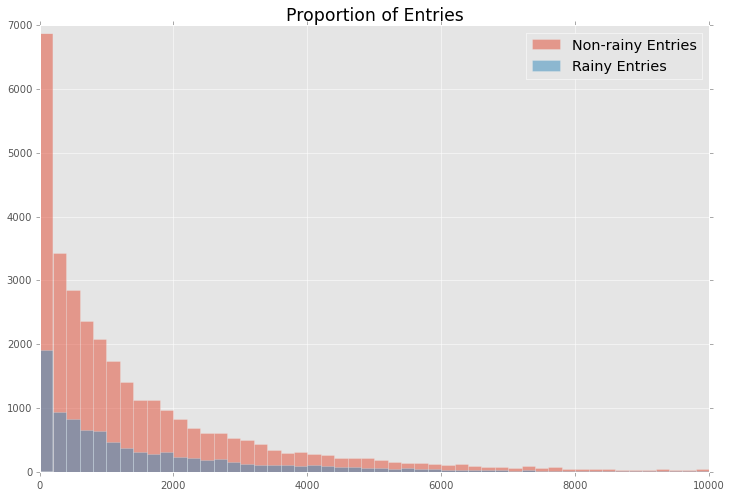

In [16]:
rainy_entries = df[df.rain == 1]['ENTRIESn_hourly']
non_rainy_entries = df[df.rain == 0]['ENTRIESn_hourly']

plt.figure(figsize=(12, 8))
non_rainy_entries.hist(range=(non_rainy_entries.min(), 10000), bins=50, alpha=0.5, label='Non-rainy Entries')
rainy_entries.hist(range=(rainy_entries.min(), 10000), bins=50, alpha=0.5, label='Rainy Entries')
plt.legend(fontsize='x-large')
plt.title('Proportion of Entries', {'fontsize': 'xx-large'})
plt.savefig('histograms.png')

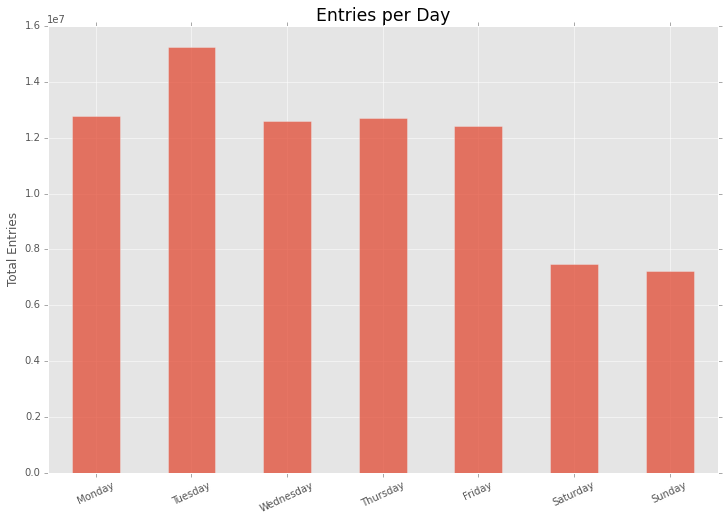

In [66]:
day_riders = df.groupby('day_week').agg(np.sum)

plt.figure()
day_riders[['ENTRIESn_hourly']].plot(kind='bar', legend=False, figsize=(12, 8), alpha=0.75)
plt.title('Entries per Day', {'fontsize':'xx-large'})
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation=25)
plt.xlabel('')
plt.ylabel('Total Entries')
plt.savefig('per_day.png')

## References

1. [MTA - Introduction to Subway Ridership](http://web.mta.info/nyct/facts/ridership/) &ndash; Accessed 16 Oct 2015
2. https://xkcd.com/1339/
3. [Nonparametric statistics](https://en.wikipedia.org/wiki/Nonparametric_statistics#Definitions)  &ndash; Accessed 16 Oct 2015
4. http://stats.stackexchange.com/questions/116315/problem-with-mann-whitney-u-test-in-scipy#116332